# ДЗ 5
Найдем какие слова чаще используют в названиях книг!!

сначала мы делаем кластеризацию текстов через kmeans и нормализуем результаты через функцию активации

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
nltk.download('stopwords')

def linear_regression(df: pd.DataFrame) -> list[float]:
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(df['clean_text'])
    kmeans = KMeans(n_clusters=5, random_state=42)
    clusters = kmeans.fit_predict(vectors)
    return clusters.tolist()

def activation_func(x: list[float]) -> list[float]:
    max_val = max(x) if max(x) != 0 else 1
    return [round(i / max_val, 2) for i in x]

def neuron(df: pd.DataFrame):
    temp_result = linear_regression(df)
    result = activation_func(temp_result)
    return result

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


тут мы считаем длину текстов находим самые частые слова и рисуем графики и облако слов чтобы посмотреть на распределение

In [2]:
def text_analysis(df):
    df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

    all_words = ' '.join(df['clean_text']).split()
    word_freq = Counter(all_words)
    common_words = word_freq.most_common(20)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    sns.histplot(df['text_length'], bins=30)
    plt.title('ДЛИНА ТЕКСТА')

    plt.subplot(2, 2, 2)
    words, counts = zip(*common_words)
    sns.barplot(x=list(counts), y=list(words))
    plt.title('ТОП 20 САМЫХ ЧАСТЫХ СЛОВ')

    plt.subplot(2, 2, 3)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['clean_text']))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('ОБЛОКО СЛОВВ')

    plt.tight_layout()
    plt.show()

тут мы смотрим сколько текстов в каждом кластере считаем статистику и выводим топ слова для каждого кластера.я взял csv файл с названиям книг чтобы выяснить.... какие слова чащи используют для названия!!

In [3]:
def analyze_clusters(df):
    cluster_sizes = df['cluster'].value_counts().sort_index()

    cluster_stats = df.groupby('cluster').agg({
        'text_length': ['mean', 'median', 'count'],
    })

    vectorizer = TfidfVectorizer(max_features=5000)
    vectors = vectorizer.fit_transform(df['clean_text'])
    feature_names = vectorizer.get_feature_names_out()

    print("\nАнализ кластеров:")
    print("Размеры кластеров:")
    print(cluster_sizes)
    print("\nСтатистика по кластерам:")
    print(cluster_stats)

    kmeans = KMeans(n_clusters=5, random_state=42).fit(vectors)
    print("\nТоп слова по кластерам:")
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    for i in range(5):
        print(f"\nКластер {i}:")
        top_words = [feature_names[ind] for ind in order_centroids[i, :10]]
        print(", ".join(top_words))

df = pd.read_csv('books.csv')
stop_words = set(stopwords.words('english'))

In [4]:
print(df.columns)


Index(['BOOKS', 'AUTHOR', 'PUBLISHERS'], dtype='object')


чистим текст от лишнего приводим к нижнему регистру убираем стоп слова потом применяем нейрон и смотрим насколько хорошо он кластеризует


In [5]:
df['text'] = df['BOOKS']

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

df['clean_text'] = df['text'].apply(preprocess)
cluster_result = neuron(df)
df['cluster'] = cluster_result

print(df[['text', 'cluster']].head())


                                             text  cluster
0  Harry Potter and the Sorcerer's Stone (Book 1)     0.25
1         Harry Potter and the Chamber of Secrets     0.25
2          Harry Potter and the Half-Blood Prince     0.25
3        Harry Potter and the Prisoner of Azkaban     0.25
4       Harry Potter and the Order of the Phoenix     0.25


иии мы превращаем тексты в векторы с помощью tfidf а потом делим данные на train val и test чтобы дальше можно было обучать модели

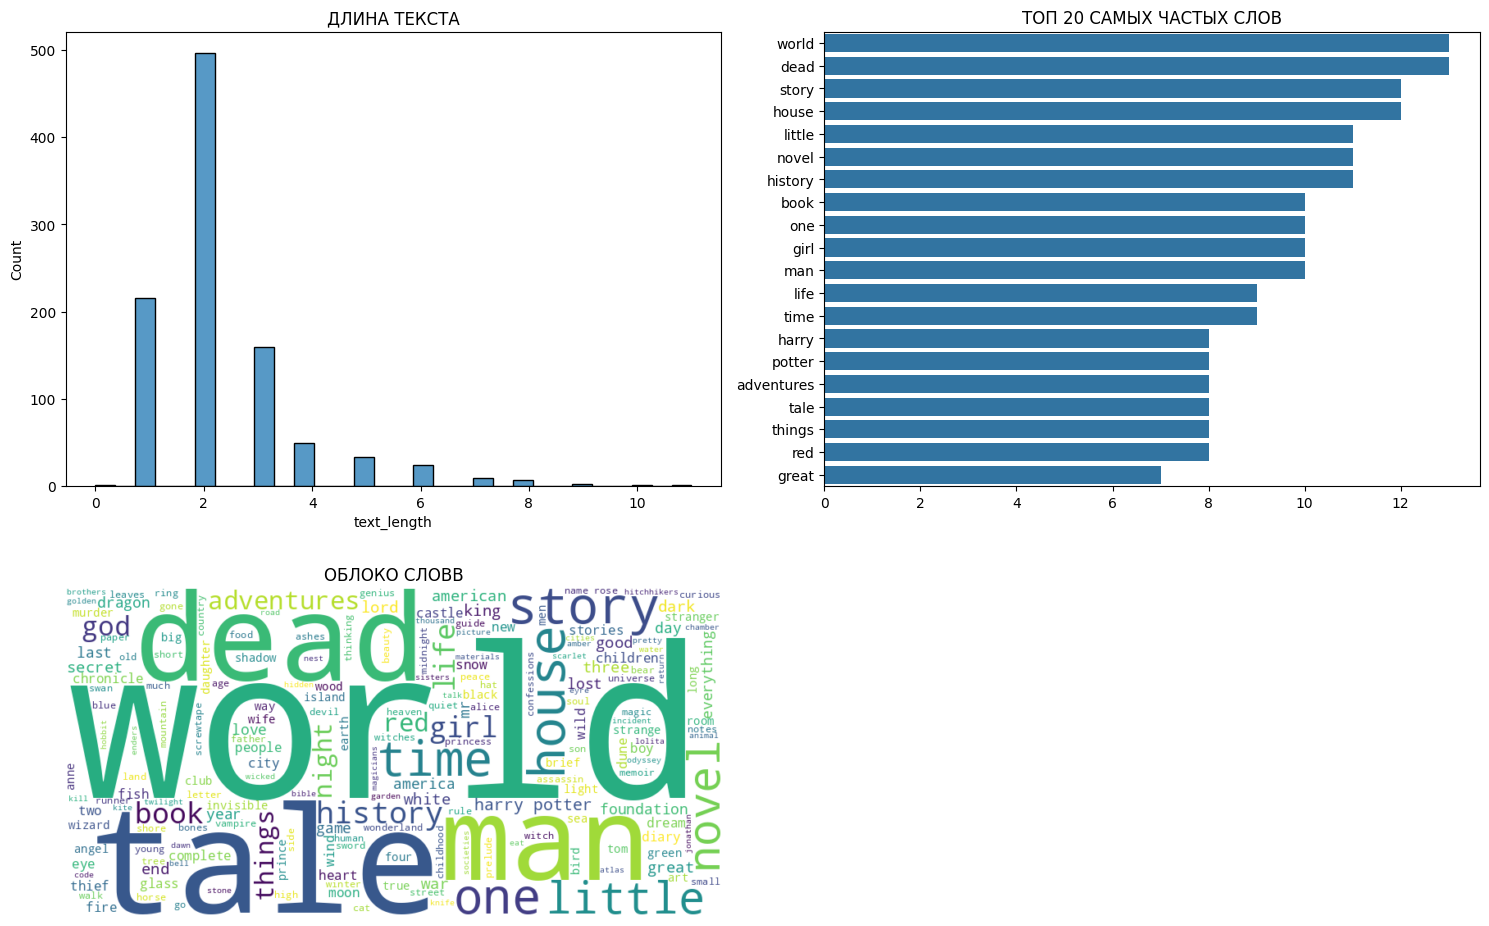

In [6]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['label'] if 'label' in df.columns else df['cluster']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
text_analysis(df)

In [7]:
analyze_clusters(df)


Анализ кластеров:
Размеры кластеров:
cluster
0.00      1
0.25    975
0.50      5
0.75     12
1.00      7
Name: count, dtype: int64

Статистика по кластерам:
        text_length             
               mean median count
cluster                         
0.00       1.000000    1.0     1
0.25       2.350769    2.0   975
0.50       2.000000    2.0     5
0.75       2.833333    2.0    12
1.00       2.571429    3.0     7

Топ слова по кластерам:

Кластер 0:
hatchet, foretold, forever, fortress, fortune, foucaults, foundation, foundations, fountainhead, four

Кластер 1:
dead, house, little, world, book, story, man, novel, girl, night

Кластер 2:
dune, heretics, messiah, children, emperor, god, forever, fortune, foucaults, foundation

Кластер 3:
red, dragon, fish, tent, mars, reborn, majestys, eyes, black, tattoo

Кластер 4:
moon, new, goodnight, fool, brave, harsh, mistress, hotel, trilogy, hampshire


тут мы видим что больше всего текстов попало в кластер 0.25 — целых 975 штук
остальные кластеры почти пустые — по 1, 5, 7 и 12 текстов
скорее всего модель плохо разделила данные и почти всё отнесла к одному кластеру, но по топ-словам видно что какие-то темы всё же различаются. нужно или больше данных или другую настройку кластера (типа n_clusters или фильтрация)

И под конец разбиваем на train, test и val выборки

In [8]:
print(f'\nРазмеры выборок:')
print(f'TRAIN(ОБУЧАЮЩ): {X_train.shape[0]}')
print(f'VAL(ВАЛИДАЦИОННАЯ): {X_val.shape[0]}')
print(f'TEST(ТЕСТОВАЯ): {X_test.shape[0]}')


Размеры выборок:
TRAIN(ОБУЧАЮЩ): 700
VAL(ВАЛИДАЦИОННАЯ): 150
TEST(ТЕСТОВАЯ): 150


# **ЛАБА 6** обучение

сначал подготовим датасет

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import torch

# Загрузка данных
df = pd.read_csv("books.csv")

# Очистка текста
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    tokens = text.split()
    filtered = [word for word in tokens if word not in stop_words]
    return " ".join(filtered)

df["text"] = df["BOOKS"]
df["clean_text"] = df["text"].apply(preprocess)

# Повторная кластеризация
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df["clean_text"])
kmeans = KMeans(n_clusters=5, random_state=42)
df["label"] = kmeans.fit_predict(vectors)

# Разделение на train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(df["clean_text"], df["label"], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_df = pd.DataFrame({"text": X_train, "label": y_train})
val_df = pd.DataFrame({"text": X_val, "label": y_val})
test_df = pd.DataFrame({"text": X_test, "label": y_test})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Преобразуем в HuggingFace Dataset

In [44]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df),
    "test": Dataset.from_pandas(test_df)
})

Токенизация

In [45]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.52.4",
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/t

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Загрузка модели

In [46]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.52.4",
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/mo

Метрика

In [47]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.from_numpy(logits).argmax(dim=-1)
    return accuracy.compute(predictions=predictions, references=labels)

Параметры обучения

In [48]:


training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="no",
    disable_tqdm=True,
    log_level="info"
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Тренировка модели

In [49]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)



<ipython-input-49-973b11a21079>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Тестирование

In [50]:
trainer.train()

The following columns in the Training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 700
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 264
  Number of trainable parameters = 66,957,317


{'loss': 1.2322, 'grad_norm': 4.926784038543701, 'learning_rate': 1.931818181818182e-05, 'epoch': 0.11363636363636363}
{'loss': 0.5188, 'grad_norm': 3.5620133876800537, 'learning_rate': 1.856060606060606e-05, 'epoch': 0.22727272727272727}
{'loss': 0.3137, 'grad_norm': 1.6643129587173462, 'learning_rate': 1.7803030303030303e-05, 'epoch': 0.3409090909090909}
{'loss': 0.1311, 'grad_norm': 0.9570971131324768, 'learning_rate': 1.7045454545454546e-05, 'epoch': 0.45454545454545453}
{'loss': 0.1563, 'grad_norm': 0.5185112357139587, 'learning_rate': 1.628787878787879e-05, 'epoch': 0.5681818181818182}
{'loss': 0.4045, 'grad_norm': 2.9279253482818604, 'learning_rate': 1.553030303030303e-05, 'epoch': 0.6818181818181818}
{'loss': 0.1982, 'grad_norm': 0.42920365929603577, 'learning_rate': 1.4772727272727274e-05, 'epoch': 0.7954545454545454}
{'loss': 0.022, 'grad_norm': 0.30797094106674194, 'learning_rate': 1.4015151515151517e-05, 'epoch': 0.9090909090909091}
{'loss': 0.0881, 'grad_norm': 0.264918982



Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 372.7678, 'train_samples_per_second': 5.634, 'train_steps_per_second': 0.708, 'train_loss': 0.2329529353953672, 'epoch': 3.0}


TrainOutput(global_step=264, training_loss=0.2329529353953672, metrics={'train_runtime': 372.7678, 'train_samples_per_second': 5.634, 'train_steps_per_second': 0.708, 'train_loss': 0.2329529353953672, 'epoch': 3.0})

In [51]:
results = trainer.evaluate(tokenized_dataset["test"])
print("\nТочность на тесте:", results["eval_accuracy"])

The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 150
  Batch size = 8


{'eval_loss': 0.046392593532800674, 'eval_accuracy': 0.9933333333333333, 'eval_runtime': 2.4935, 'eval_samples_per_second': 60.155, 'eval_steps_per_second': 7.62, 'epoch': 3.0}

Точность на тесте: 0.9933333333333333
